# Single-cell kymograph maker
This notebook is for making kymographs focused on a single apoptotic scribble cell and checking the kymographs against empirical biological knowledge

In [1]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
from tqdm import tqdm
import timeit ## can remove after assessing speed of different methods

version no.: 0.4.0


In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist(target_track, other_track, frame, apop_index):
    try:
        idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist_mito(target_track, other_track, apop_index):
    idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
    idx1 = -1 ## t[-1] is the final frame, ie the frame of mitosis
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    try:
        if target_track.label[0] == 'APOPTOSIS': ## if the first classification is apoptosis then thats a duff track
            print("False apoptosis Scr ID:", target_track.ID)
            apop_index = apop_time = False
            if index == True: 
                return apop_index
            else: 
                return apop_time
        else: 
            for i, j in enumerate(target_track.label):
                if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
                    apop_index = i
                    break
            apop_time = target_track.t[apop_index]
            if index == True: 
                return apop_index
            else: 
                return apop_time
    except: 
        print("False apoptosis Scr ID:", target_track.ID)
        apop_index = apop_time = False
        if index == True: 
            return apop_index
        else: 
            return apop_time
    
def kymo_labels(num_bins, label_freq):
    radial_bin = radius / num_bins
    temporal_bin = t_range*2 / num_bins
#     print("Radius, time_range:", radius,",", (t_range*2))
#     print("Size radial bin:", radial_bin)
#     print("Size temporal bin:", temporal_bin)
#     print("No. bins:",num_bins)

    ## label frequence, ie num labels per bin
    #label_freq = 1

    ### generate labels for axis PIXELS/FRAMES
    xlocs = range(0, num_bins,label_freq) ## step of 2 to avoid crowding
    xlabels = []
    for m in range(int(-num_bins/2), int(num_bins/2),label_freq):
        xlabels.append(str(int((temporal_bin)*m)) + "," + str(int((temporal_bin)*m+temporal_bin)))
    #print("xlabels:",xlabels, type(xlabels))

    ylocs = range(0, num_bins, label_freq) ## step of 2 to avoid crowding
    ylabels = []
    for m in range(num_bins, 0, -label_freq):
        ylabels.append(str(int((radial_bin)*m)) + "," + str(int((radial_bin)*(m-1))))
    #print("ylabels:", ylabels, type(ylabels))
    
    return xlocs, xlabels, ylocs, ylabels


In [3]:
expt_path = '/home/nathan/data/kraken/h2b/giulia/GV0807/'
tracks_fn = os.path.join(expt_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
for i in range(len(scr_tracks)):
    scr_tracks[i].ID = -(scr_tracks[i].ID)
all_tracks = wt_tracks + scr_tracks ### negative IDs are scribble cells
print("Track information loaded and ordered according to cell type")

[INFO][2021/01/28 12:07:57 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/28 12:07:57 PM] Loading tracks/obj_type_1
[INFO][2021/01/28 12:07:59 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2021/01/28 12:08:03 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/01/28 12:08:03 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/28 12:08:03 PM] Loading tracks/obj_type_2
[INFO][2021/01/28 12:08:03 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2021/01/28 12:08:03 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type


# to-do week from 21st Jan:

- [x] check the order of the histogram (col, row) in right orientation
- [x] put scr_tracks.IDs into the IMAGINARY (-ve)
- [x] combine wt_tracks + scr_tracks, retain option to just inc one (see above)
- [x] save out histograms as .npy arrays
- [ ] get list of real apoptoses from Chris
- [ ] sanity check for doubling times, shd be on the order of doubling cell number
- [ ] normalise?
- [x] input correct bin edges


In [717]:
[scr_track.ID for scr_track in scr_tracks if len(scr_track) >300]

[-2, -1, -5, -3, -4, -16, -17, -29, -50]

# Calculate raw data for one cell (calculate neighbouring no. cells and mitoses)

In [4]:
print("Input cell type: 'WT' or 'Scr'")
cell_type = input()
print("Input cell ID (if Scr then ID should be negative)")
cell_ID = int(input())

if cell_type == 'Scr':
    #index = [i for i, scr_apop in enumerate(scr_tracks) if scr_apop.ID == cell_ID][0]
    target_track = [scr_track for scr_track in scr_tracks if scr_track.ID == cell_ID][0]
    
    #target_track = scr_tracks[index]##### Show the first classification of each track
    ### if a scr cell is picked, the focal timepoint is its apoptosis
    apop_time = find_apoptosis_time(target_track, index = False)
    apop_index = find_apoptosis_time(target_track, index = True)
    
if cell_type == 'WT':
    index = [i for i, wt_track in enumerate(wt_tracks) if wt_track.ID == cell_ID][0]
    target_track = wt_tracks[index]##### Show the first classification of each track
    ### if a wt cell is picked, the focal time point is a random point in its track as this measurement will serve as a control
    apop_time = random.choice(target_track.t)
    apop_index = target_track.t.index(apop_time)

Input cell type: 'WT' or 'Scr'
Scr
Input cell ID (if Scr then ID should be negative)
-17


In [1]:
target_track

NameError: name 'target_track' is not defined

In [796]:
shape_tyx = (1176, 1377, 1739) 

#### Pick a temporal and radial range to scan over

In [6]:
radius = 400
t_range = 200 ### actual range will be twice this as it scans neg and pos

#### Scanning over every cell (both WT and Scr)

In [7]:
start = timeit.default_timer()
cells = [tuple(((any_cell.ID),
                  (round((euc_dist(target_track, any_cell, (apop_time+delta_t), apop_index)),2)),
                  ((apop_time + delta_t)))) 
           for delta_t in range(-t_range, t_range)
           for any_cell in all_tracks 
               if euc_dist(target_track, any_cell, apop_time + delta_t, apop_index)<radius
           ]
stop = timeit.default_timer()

print('Any cell counter calculation time: ', round((stop - start),2), 'seconds') 

Any cell counter calculation time:  45.99 seconds


#### Scanning over every cell for mitoses

In [33]:
start = timeit.default_timer()
### count number of mitoses
any_cell_mito = [tuple(((any_cell.ID),
                  (round((euc_dist_mito(target_track, any_cell, apop_index)),2)),
                  (any_cell.t[-1]),
                  (any_cell.label[-1]),
                  (any_cell.fate.name))) 
           for any_cell in all_tracks
            if 
            euc_dist_mito(target_track, any_cell, apop_index)<radius and ## within the full radial extent
            any_cell.fate.name == "DIVIDE" 
           ]
stop = timeit.default_timer()

print('Any cell mitosis cell counter calculation time: ', round((stop - start),2), 'seconds') 

Any cell mitosis cell counter calculation time:  121.68 seconds


# Save measurments out


In [800]:
if cell_type == 'Scr':
    raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')
    no_cells_fn = os.path.join(raw_numbers_path,('no_cells_Scr_ID_' + str(cell_ID) + '.csv'))
    no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_Scr_ID_' + str(cell_ID) + '.csv'))
if cell_type == 'WT':
    raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers/controls')
    no_cells_fn = os.path.join(raw_numbers_path,('no_cells_WT_ID_' + str(cell_ID) + '.csv'))
    no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_WT_ID_' + str(cell_ID) + '.csv'))


with open(no_cells_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame')
    for listitem in cells:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

with open(no_cells_mito_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
    for listitem in any_cell_mito:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

# Plotting data from one event into kymographs

#### Getting xy variables

In [9]:
all_cells_distance = [cells[i][1] for i in range(0,len(cells))]
all_cells_time = [cells[i][2] for i in range(0,len(cells))]

all_cells_distance_mito = [any_cell_mito[i][1] for i in range(0,len(any_cell_mito))]
all_cells_time_mito = [any_cell_mito[i][2] for i in range(0,len(any_cell_mito))]

Text(0.5, 1.0, 'Cumulative count of wild-type cell MITOSES over all frames \nscanning radially outward from ScrKD cell death')

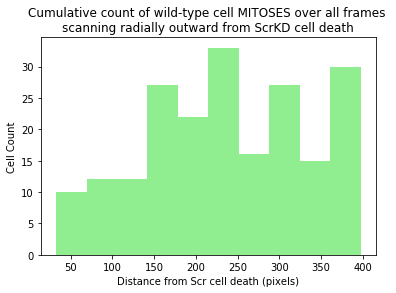

In [40]:
plt.hist(all_cells_distance_mito, bins =10, cumulative = False, color='#90ee90')
plt.ylabel('Cell Count')
plt.xlabel('Distance from Scr cell death (pixels)')
plt.title('Cumulative count of wild-type cell MITOSES over all frames \nscanning radially outward from ScrKD cell death')

Text(0.5, 1.0, 'Cumulative count of wild-type cells MITOSES over all distance \nscanning temporally before and after ScrKD cell death')

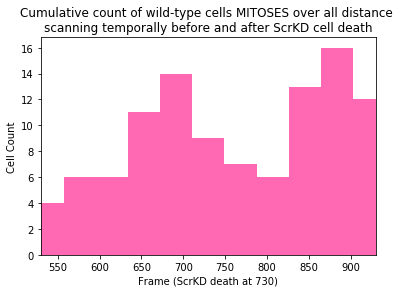

In [39]:
plt.hist(all_cells_time_mito, bins=30, cumulative=False, color = '#ff69b4')
plt.ylabel('Cell Count')
plt.xlabel('Frame (ScrKD death at 730)')
plt.xlim(5,930)
plt.title('Cumulative count of wild-type cells MITOSES over all distance \nscanning temporally before and after ScrKD cell death')

# Plotting all_cells

Text(21, 23, 'expt:GV0807\n 90:10 WT:Scr')

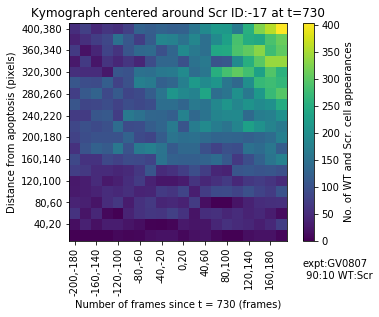

In [42]:
num_bins = 20
time_bin_edges = np.linspace((-(t_range)+apop_time),(t_range+apop_time), num_bins+1) ## 2dimensionalise
distance_bin_edges = np.linspace(0,radius, num_bins+1) ## 2dimensionalise
H_num_cells, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance,all_cells_time, bins=[distance_bin_edges,time_bin_edges])
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell/controls',('no_all_cells_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell',('no_all_cells_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_num_cells))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of WT and Scr. cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins+1,num_bins+3,expt_label)
# plt.savefig(no_all_cells_fn, bbox_inches = 'tight', dpi = 300)
# np.save(no_all_cells_fn[0:-4],H_num_cells)

Text(21, 24, 'expt:GV0807\n 90:10 WT:Scr')

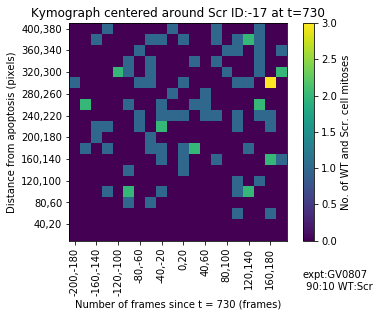

In [43]:
num_bins = 20
H_num_mito, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance_mito,all_cells_time_mito, bins=[distance_bin_edges,time_bin_edges])
#H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('no_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('no_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_num_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of WT and Scr. cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins+1,num_bins+4,expt_label)
# plt.savefig(no_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
# np.save(no_all_cells_mito_fn[0:-4],H_num_mito)

Text(20, 24, 'expt:GV0807\n 90:10 WT:Scr')

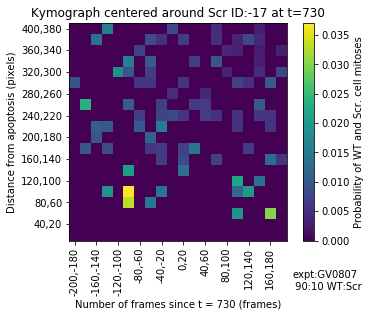

In [46]:
num_bins = 20
H_prob_mito = H_num_mito/(H_num_cells+1E-10)
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('prob_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('prob_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_prob_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'Probability of WT and Scr. cell mitoses')
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins, num_bins+4,expt_label)
# plt.savefig(prob_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
# np.save(prob_all_cells_mito_fn[0:-4],H_prob_mito)

# sanity checks -- 

#### New attempt: temporal evolution

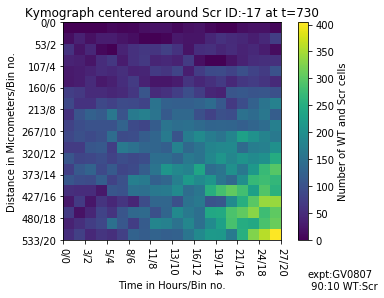

In [47]:
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    labelled_kymo_fn = os.path.join(expt_path, 'analysis/validations', ('labelled_kymo_WT_ID_:' + str(target_track.ID)  +'.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time)
    labelled_kymo_fn = os.path.join(expt_path, 'analysis/validations', ('labelled_kymo_Scr_ID_:'+ str(target_track.ID) +'.png'))
xtick_loc = [i-0.5 for i in range(0, len(time_bin_edges),2)]
xtick_lab = [str(round(i*4/60))+str('/')+str(int(i/20)) for i in range(0,420, 40)]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
plt.xticks(xtick_loc, xtick_lab, rotation='-90')
ytick_loc = [i-0.5 for i in range(0, len(distance_bin_edges),2)]
ytick_lab = [str(round(i*1.3333))+str('/')+str(int(i/20)) for i in range(0,420, 40)]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
plt.xticks(xtick_loc, xtick_lab)#, rotation='45')
plt.yticks(ytick_loc, ytick_lab)
plt.xlabel('Time in Hours/Bin no.')
plt.ylabel('Distance in Micrometers/Bin no.')
plt.title(title)
plt.imshow(H_num_cells)
plt.colorbar(label = 'Number of WT and Scr cells')
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins+2, num_bins+4,expt_label)
plt.savefig(labelled_kymo_fn, bbox_to_inches = 'tight')

#### Plotting spatial distribution for a time point

In [810]:
if cell_type == 'WT':
    title = 'Spatial distribution of cells \n(at different time points [shaded]), WT ID:' + str(target_track.ID) ##cell type and ID
    spatial_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Spatial_Dist_Cells_WT_ID_' + str(target_track.ID)  +'.png'))
if cell_type == 'Scr':
    title = 'Spatial distribution of cells \n(at different time points [shaded]), Scr ID:' + str(target_track.ID)
    spatial_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Spatial_Dist_Cells_Scr_ID_:'+ str(target_track.ID) +'.png'))
for i in range(len(H_num_cells[:,19])):
    if i > -1:
        plt.plot(H_num_cells[:,i], linewidth = 0.1)#
xtick_loc = [i for i in range(0, len(distance_bin_edges)+1)]
xtick_lab = [int(i*1.3333) for i in range(0,int(radius+(radius/num_bins)), int(radius/num_bins))]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
plt.xticks(xtick_loc, xtick_lab, rotation='-90')
plt.xlabel('Radial Distance (micrometers)')
plt.ylabel('Cell Count')
avg_H_num, sum_H_num = np.zeros(20),np.zeros(20) ## averaging spatial dist plots
count = 0
for i in range(len(H_num_cells[:,19])):
    if i > 10:
        count += 1
        sum_H_num += H_num_cells[:,i]
avg_H_num = sum_H_num/count
plt.plot(avg_H_num, c = 'r', label = 'Average over \ntime bins')
#plt.plot(H_num_cells[:,19], c = 'c', label = 'Last time bin (t = 27hrs)')
plt.grid()
plt.legend()
#plt.ylim(0,400)
#plt.xlim(0,19)
# x = range(len(H_num_cells[:,19])) ### linear line of best fit
# z = np.polyfit(x,H_num_cells[:,19],1)
# p = np.poly1d(z)
# plt.plot(x,p(x))
plt.title(title)
plt.savefig(spatial_dist_fn, bbox_inches = 'tight', dpi = 300)
plt.clf()

<Figure size 432x288 with 0 Axes>

#### condense all distance bins down to one and plot temporally

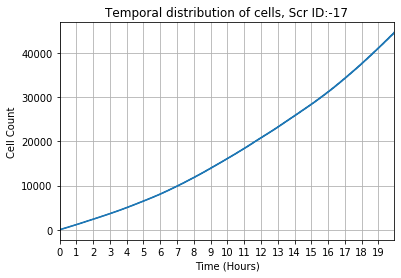

In [49]:
if cell_type == 'WT':
    title = 'Temporal distribution of cells, WT ID:' + str(target_track.ID) ##cell type and ID
    temporal_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Temporal_Dist_Cells_WT_ID_' + str(target_track.ID)  +'.png'))
if cell_type == 'Scr':
    title = 'Temporal distribution of cells, Scr ID:' + str(target_track.ID)
    temporal_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Temporal_Dist_Cells_Scr_ID_:'+ str(target_track.ID) +'.png'))
### multiple counts of each cell per frame
plt.title(title)
xtick_loc = range(min(all_cells_time),max(all_cells_time),int(t_range*2/num_bins))
xtick_lab = range(0,int((max(all_cells_time)-min(all_cells_time))*4/60),int((t_range*2/num_bins)*4/60))
plt.xticks(xtick_loc, xtick_lab)#, rotation='-90')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell Count')
plt.grid()
#plt.ylim(0,50000)
plt.xlim(min(all_cells_time),max(all_cells_time))
plt.plot(all_cells_time,range(len(all_cells_time)))
#plt.savefig(temporal_dist_fn,dpi=300,bbox_inches='tight')


# Iterate over many cells generating validation graphs

In [818]:
expt_path = '/home/nathan/data/kraken/h2b/giulia/GV0812/'
tracks_fn = os.path.join(expt_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
for i in range(len(scr_tracks)):
    scr_tracks[i].ID = -(scr_tracks[i].ID)
all_tracks = wt_tracks + scr_tracks ### negative IDs are scribble cells
print("Track information loaded and ordered according to cell type")

[INFO][2021/01/24 08:10:13 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/24 08:10:13 PM] Loading tracks/obj_type_1
[INFO][2021/01/24 08:10:14 PM] Loading objects/obj_type_1 (205743, 5) (192777 filtered: area>=100)
[INFO][2021/01/24 08:10:16 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/01/24 08:10:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/24 08:10:16 PM] Loading tracks/obj_type_2
[INFO][2021/01/24 08:10:17 PM] Loading objects/obj_type_2 (39202, 5) (33022 filtered: area>=100)
[INFO][2021/01/24 08:10:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type


In [821]:
start = timeit.default_timer()
### list of ids
list_of_IDs = [ID.ID for ID in scr_tracks if len(ID) > 300]

for cell_ID in list_of_IDs:
    
    try:
        if cell_type == 'Scr':
            #index = [i for i, scr_apop in enumerate(scr_tracks) if scr_apop.ID == cell_ID][0]
            target_track = [scr_track for scr_track in scr_tracks if scr_track.ID == cell_ID][0]

            #target_track = scr_tracks[index]##### Show the first classification of each track
            ### if a scr cell is picked, the focal timepoint is its apoptosis
            apop_time = find_apoptosis_time(target_track, index = False)
            apop_index = find_apoptosis_time(target_track, index = True)
            if apop_time == False:
                print("Cell ID:",cell_type, target_track.ID, "False apop")
                continue
        if cell_type == 'WT':
            index = [i for i, wt_track in enumerate(wt_tracks) if wt_track.ID == cell_ID][0]
            target_track = wt_tracks[index]##### Show the first classification of each track
            ### if a wt cell is picked, the focal time point is a random point in its track as this measurement will serve as a control
            apop_time = random.choice(target_track.t)
            apop_index = target_track.t.index(apop_time)
            if apop_time == False:
                print("Cell ID:",cell_type, target_track.ID, "False apop")
                continue

        #### Pick a temporal and radial range to scan over

        radius = 400
        t_range = 200 ### actual range will be twice this as it scans neg and pos

        #### Scanning over every cell (both WT and Scr)

        cells = [tuple(((any_cell.ID),
                          (round((euc_dist(target_track, any_cell, (apop_time+delta_t), apop_index)),2)),
                          ((apop_time + delta_t)))) 
                   for delta_t in range(-t_range, t_range)
                   for any_cell in all_tracks 
                       if euc_dist(target_track, any_cell, apop_time + delta_t, apop_index)<radius
                   ]


        #### Scanning over every cell for mitoses

        ### count number of mitoses
        any_cell_mito = [tuple(((any_cell.ID),
                          (round((euc_dist_mito(target_track, any_cell, apop_index)),2)),
                          (any_cell.t[-1]),
                          (any_cell.label[-1]),
                          (any_cell.fate.name))) 
                   for any_cell in all_tracks
                    if 
                    euc_dist_mito(target_track, any_cell, apop_index)<radius and ## within the full radial extent
                    any_cell.fate.name == "DIVIDE" 
                   ]


        # Save measurments out


        if cell_type == 'Scr':
            raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')
            no_cells_fn = os.path.join(raw_numbers_path,('no_cells_Scr_ID_' + str(cell_ID) + '.csv'))
            no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_Scr_ID_' + str(cell_ID) + '.csv'))
        if cell_type == 'WT':
            raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers/controls')
            no_cells_fn = os.path.join(raw_numbers_path,('no_cells_WT_ID_' + str(cell_ID) + '.csv'))
            no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_WT_ID_' + str(cell_ID) + '.csv'))


        with open(no_cells_fn, 'w') as filehandle:
            filehandle.write('%s\n'%'ID, Distance, Frame')
            for listitem in cells:
                filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

        with open(no_cells_mito_fn, 'w') as filehandle:
            filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
            for listitem in any_cell_mito:
                filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

        # Plotting data from one event into kymographs

        #### Getting xy variables

        all_cells_distance = [cells[i][1] for i in range(0,len(cells))]
        all_cells_time = [cells[i][2] for i in range(0,len(cells))]

        all_cells_distance_mito = [any_cell_mito[i][1] for i in range(0,len(any_cell_mito))]
        all_cells_time_mito = [any_cell_mito[i][2] for i in range(0,len(any_cell_mito))]

        # Plotting all_cells

        num_bins = 20
        time_bin_edges = np.linspace((-(t_range)+apop_time),(t_range+apop_time), num_bins+1) ## 2dimensionalise
        distance_bin_edges = np.linspace(0,radius, num_bins+1) ## 2dimensionalise
        H_num_cells, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance,all_cells_time, bins=[distance_bin_edges,time_bin_edges])
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell/controls',('no_all_cells_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell',('no_all_cells_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_num_cells))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'No. of WT and Scr. cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins+1,num_bins+3,expt_label)
        # plt.savefig(no_all_cells_fn, bbox_inches = 'tight', dpi = 300)
        # np.save(no_all_cells_fn[0:-4],H_num_cells)
        plt.clf()

        num_bins = 20
        H_num_mito, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance_mito,all_cells_time_mito, bins=[distance_bin_edges,time_bin_edges])
        #H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('no_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('no_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_num_mito))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'No. of WT and Scr. cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins+1,num_bins+4,expt_label)
        # plt.savefig(no_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
        # np.save(no_all_cells_mito_fn[0:-4],H_num_mito)
        plt.clf()

        num_bins = 20
        H_prob_mito = H_num_mito/(H_num_wt+1E-10)
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('prob_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('prob_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_prob_mito))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'Probability of WT and Scr. cell mitoses')
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins, num_bins+4,expt_label)
        # plt.savefig(prob_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
        # np.save(prob_all_cells_mito_fn[0:-4],H_prob_mito)
        plt.clf()

        # sanity checks -- 

        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            labelled_kymo_fn = os.path.join(expt_path, 'analysis/validations', ('labelled_kymo_WT_ID_:' + str(target_track.ID)  +'.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time)
            labelled_kymo_fn = os.path.join(expt_path, 'analysis/validations', ('labelled_kymo_Scr_ID_:'+ str(target_track.ID) +'.png'))
        xtick_loc = [i-0.5 for i in range(0, len(time_bin_edges),2)]
        xtick_lab = [str(round(i*4/60))+str('/')+str(int(i/20)) for i in range(0,420, 40)]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
        plt.xticks(xtick_loc, xtick_lab, rotation='-90')
        ytick_loc = [i-0.5 for i in range(0, len(distance_bin_edges),2)]
        ytick_lab = [str(round(i*1.3333))+str('/')+str(int(i/20)) for i in range(0,420, 40)]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
        plt.xticks(xtick_loc, xtick_lab)#, rotation='45')
        plt.yticks(ytick_loc, ytick_lab)
        plt.xlabel('Time in Hours/Bin no.')
        plt.ylabel('Distance in Micrometers/Bin no.')
        plt.title(title)
        plt.imshow(H_num_cells)
        plt.colorbar(label = 'Number of WT and Scr cells')
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins+2, num_bins+4,expt_label)
        plt.savefig(labelled_kymo_fn, bbox_to_inches = 'tight')
        plt.clf()

        #### Plotting spatial distribution for a time point

        if cell_type == 'WT':
            title = 'Spatial distribution of cells \n(at different time points [shaded]), WT ID:' + str(target_track.ID) ##cell type and ID
            spatial_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Spatial_Dist_Cells_WT_ID_' + str(target_track.ID)  +'.png'))
        if cell_type == 'Scr':
            title = 'Spatial distribution of cells \n(at different time points [shaded]), Scr ID:' + str(target_track.ID)
            spatial_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Spatial_Dist_Cells_Scr_ID_:'+ str(target_track.ID) +'.png'))
        for i in range(len(H_num_cells[:,19])):
            if i > -1:
                plt.plot(H_num_cells[:,i], linewidth = 0.1)#
        xtick_loc = [i for i in range(0, len(distance_bin_edges)+1)]
        xtick_lab = [int(i*1.3333) for i in range(0,int(radius+(radius/num_bins)), int(radius/num_bins))]#shows hours and bin (multiply by bin size to change to frame) [round(i*4/60,2) for i in range(0,210, 10)] #in hours, range(0,210,10) ## in frames
        plt.xticks(xtick_loc, xtick_lab, rotation='-90')
        plt.xlabel('Radial Distance (micrometers)')
        plt.ylabel('Cell Count')
        avg_H_num, sum_H_num = np.zeros(20),np.zeros(20) ## averaging spatial dist plots
        count = 0
        for i in range(len(H_num_cells[:,19])):
            if i > 10:
                count += 1
                sum_H_num += H_num_cells[:,i]
        avg_H_num = sum_H_num/count
        plt.plot(avg_H_num, c = 'r', label = 'Average over \ntime bins')
        #plt.plot(H_num_cells[:,19], c = 'c', label = 'Last time bin (t = 27hrs)')
        plt.grid()
        plt.legend()
        #plt.ylim(0,400)
        #plt.xlim(0,19)
        # x = range(len(H_num_cells[:,19])) ### linear line of best fit
        # z = np.polyfit(x,H_num_cells[:,19],1)
        # p = np.poly1d(z)
        # plt.plot(x,p(x))
        plt.title(title)
        plt.savefig(spatial_dist_fn, bbox_inches = 'tight', dpi = 300)
        plt.clf()

        #### condense all distance bins down to one and plot temporally

        if cell_type == 'WT':
            title = 'Temporal distribution of cells, WT ID:' + str(target_track.ID) ##cell type and ID
            temporal_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Temporal_Dist_Cells_WT_ID_' + str(target_track.ID)  +'.png'))
        if cell_type == 'Scr':
            title = 'Temporal distribution of cells, Scr ID:' + str(target_track.ID)
            temporal_dist_fn = os.path.join(expt_path, 'analysis/validations', ('Temporal_Dist_Cells_Scr_ID_:'+ str(target_track.ID) +'.png'))
        ### multiple counts of each cell per frame
        plt.title(title)
        xtick_loc = range(min(all_cells_time),max(all_cells_time),int(t_range*2/num_bins))
        xtick_lab = range(0,int((max(all_cells_time)-min(all_cells_time))*4/60),int((t_range*2/num_bins)*4/60))
        plt.xticks(xtick_loc, xtick_lab)#, rotation='-90')
        plt.xlabel('Time (Hours)')
        plt.ylabel('Cell Count')
        plt.grid()
        #plt.ylim(0,50000)
        plt.xlim(min(all_cells_time),max(all_cells_time))
        plt.plot(all_cells_time,range(len(all_cells_time)))
        plt.savefig(temporal_dist_fn,dpi=300,bbox_inches='tight')
        plt.clf()
        mssg = "Cell ID "+ cell_ID +" succesful"
        send_text_message(mssg)
    except:
        mssg = "Cell ID "+ cell_ID+ " failed for some unknown reason"
        print(mssg)
        send_text_message(mssg)
stop = timeit.default_timer()
print('Job complete, calculation time: ', round((stop - start)/60,2), 'minutes') 
complete_mssg = 'Job complete, calculation time: '+str( round((stop - start)/60,2))+ ' minutes'
send_text_message(complete_mssg)

False apoptosis Scr ID: -18
False apoptosis Scr ID: -18
Cell ID: Scr -18 False apop
False apoptosis Scr ID: -19
False apoptosis Scr ID: -19
Cell ID: Scr -19 False apop
False apoptosis Scr ID: -20
False apoptosis Scr ID: -20
Cell ID: Scr -20 False apop
False apoptosis Scr ID: -22
False apoptosis Scr ID: -22
Cell ID: Scr -22 False apop
False apoptosis Scr ID: -23
False apoptosis Scr ID: -23
Cell ID: Scr -23 False apop
False apoptosis Scr ID: -24
False apoptosis Scr ID: -24
Cell ID: Scr -24 False apop
False apoptosis Scr ID: -25
False apoptosis Scr ID: -25
Cell ID: Scr -25 False apop
False apoptosis Scr ID: -27
False apoptosis Scr ID: -27
Cell ID: Scr -27 False apop
False apoptosis Scr ID: -30
False apoptosis Scr ID: -30
Cell ID: Scr -30 False apop
False apoptosis Scr ID: -31
False apoptosis Scr ID: -31
Cell ID: Scr -31 False apop
False apoptosis Scr ID: -32
False apoptosis Scr ID: -32
Cell ID: Scr -32 False apop
False apoptosis Scr ID: -3
False apoptosis Scr ID: -3
Cell ID: Scr -3 False 

<Figure size 432x288 with 0 Axes>

#### Previous attempt - got a bit fiddly

[-25.6, -22.4, -19.2, -16.0, -12.8, -9.6, -6.4, -3.2, 0.0, 3.2, 6.4, 9.6, 12.8, 16.0, 19.2, 22.4, 25.6, 28.8, 32.0, 35.2, 38.4, 41.6, 44.8, 48.0, 51.2, 54.4, 57.6, 60.8, 64.0, 67.2, 70.4, 73.6, 76.8, 80.0, 83.2, 86.4, 89.6, 92.8, 96.0, 99.2, 102.4, 105.6, 108.8, 112.0, 115.2, 118.4, 121.6, 124.8, 128.0, 131.2]
suggested xlims 15.3125 70.4375
number of frames per bin 24.0 number of mins/hrs per bin 1.6


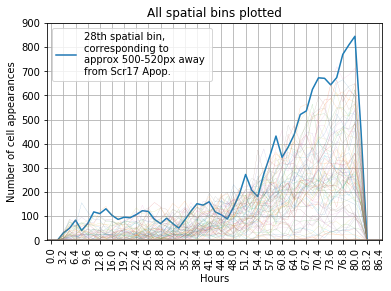

In [386]:
## H_num_cells[distance,time]

num_bins = 98 ### is 98 to fine a sampling?
time_bin_edges = np.linspace((-(t_range)+apop_time),(t_range+apop_time), num_bins+1) ## 2dimensionalise
distance_bin_edges = np.linspace(0,radius, num_bins+1) 
H_num_cells_2, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance,all_cells_time, bins=[distance_bin_edges,time_bin_edges])
#plt.imshow(np.flipud(H_num_cells))
#plt.xlim(0.18*num_bins,num_bins-(0.31*num_bins))
#plt.ylim(20,98)


# add scaled time to x axis
### frame labels
# xlabels = []
# step = 2
# xlocs = range(0,num_bins,step)
# for i in range(0,len(time_bin_edges),step):
#     xlabels.append(round(time_bin_edges[i])+62) ## ADDING FRAME SHIFT  
### hour labels
xlabels = []
step = 2
xlocs = range(0,num_bins,step)
for i in range(0,len(time_bin_edges),step):
    xlabels.append(round(((time_bin_edges[i]*4/60)+(62*4/60)),2)) ## ADDING FRAME SHIFT  
print(xlabels)
print("suggested xlims",0.15625*num_bins, num_bins-(0.28125*num_bins)) ## fraction of x that exists before/after movie starts
### want frames per bin to be an integer
frames_per_bin = t_range*2/num_bins
print("number of frames per bin",frames_per_bin, "number of mins/hrs per bin",frames_per_bin*4/60)
plt.xticks(xlocs,xlabels, rotation='vertical')
plt.plot(H_num_cells[28,:], label = '28th spatial bin, \ncorresponding to \napprox 500-520px away \nfrom Scr17 Apop.')
plt.legend()
for i in range(0,len(H_num_cells[:,0])):
    plt.plot(H_num_cells[i,:], linewidth = 0.1)
plt.xlim(0.15625*num_bins,num_bins-(0.28125*num_bins))
plt.ylim(0,900)
plt.xlabel('Hours')
plt.ylabel('Number of cell appearances')
plt.title('All spatial bins plotted')
plt.grid()
plt.savefig('/home/nathan/data/kraken/h2b/giulia/GV0807/analysis/validations/No_all_cells_temporal_evo_all_spatial_bins.png',bbox_inches = 'tight', dpi=300)

In [382]:
no_all_cells_fn

'/home/nathan/data/kraken/h2b/giulia/GV0807/analysis/single_cell/no_all_cells_Scr_ID_-17.png'

In [344]:
x = np.linspace(25, 60, 98-18)
#print(x)
t = 60
Nt, N0 = 646, 1
gr = np.log(Nt/N0)/t
#np.exp(x*gr)

[25.         25.44303797 25.88607595 26.32911392 26.7721519  27.21518987
 27.65822785 28.10126582 28.5443038  28.98734177 29.43037975 29.87341772
 30.3164557  30.75949367 31.20253165 31.64556962 32.08860759 32.53164557
 32.97468354 33.41772152 33.86075949 34.30379747 34.74683544 35.18987342
 35.63291139 36.07594937 36.51898734 36.96202532 37.40506329 37.84810127
 38.29113924 38.73417722 39.17721519 39.62025316 40.06329114 40.50632911
 40.94936709 41.39240506 41.83544304 42.27848101 42.72151899 43.16455696
 43.60759494 44.05063291 44.49367089 44.93670886 45.37974684 45.82278481
 46.26582278 46.70886076 47.15189873 47.59493671 48.03797468 48.48101266
 48.92405063 49.36708861 49.81012658 50.25316456 50.69620253 51.13924051
 51.58227848 52.02531646 52.46835443 52.91139241 53.35443038 53.79746835
 54.24050633 54.6835443  55.12658228 55.56962025 56.01265823 56.4556962
 56.89873418 57.34177215 57.78481013 58.2278481  58.67088608 59.11392405
 59.55696203 60.        ]


array([ 14.82279887,  15.54822719,  16.30915799,  17.10732878,
        17.94456207,  18.82276959,  19.74395662,  20.71022657,
        21.72378582,  22.78694868,  23.90214278,  25.07191452,
        26.29893493,  27.58600576,  28.93606588,  30.352198  ,
        31.83763567,  33.39577072,  35.03016095,  36.7445383 ,
        38.54281734,  40.42910423,  42.40770606,  44.48314073,
        46.66014726,  48.94369656,  51.33900285,  53.85153552,
        56.48703163,  59.25150901,  62.15128001,  65.19296592,
        68.38351204,  71.7302036 ,  75.24068238,  78.92296411,
        82.78545684,  86.83698011,  91.08678507,  95.54457565,
       100.22053065, 105.12532707, 110.2701644 , 115.66679025,
       121.32752717, 127.26530076, 133.49366921, 140.02685424,
       146.87977357, 154.06807503, 161.60817223, 169.51728205,
       177.813464  , 186.51566139, 195.64374464, 205.21855662,
       215.26196024, 225.79688841, 236.84739634, 248.43871652,
       260.59731634, 273.35095848, 286.72876433, 300.76

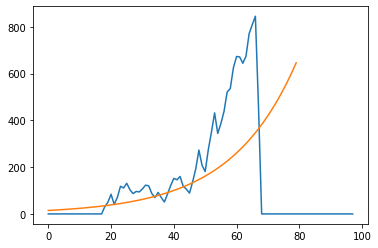

In [370]:
### overlaying exp curve
plt.plot(H_num_cells[28,:])
plt.plot(np.exp(x*gr))
#plt.plot((np.exp(range(0,72))))